In [1]:
import os
import sys

import flopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapefile as sf
from flopy.utils.gridgen import Gridgen
from flopy.utils.reference import SpatialReference
from scipy.interpolate import griddata

In [2]:
print(sys.version)
print("numpy version: {}".format(np.__version__))
print("flopy version: {}".format(flopy.__version__))

3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]
numpy version: 1.23.3
flopy version: 3.3.2


In [3]:
def ShowMap():
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_aspect("equal")
    modelmap = flopy.plot.PlotMapView(model=mf, ax=ax)
    quadmesh = modelmap.plot_array(ztop)


def ShowCrossSection(row):
    fig = plt.figure(figsize=(20, 3))
    ax = fig.add_subplot(1, 1, 1)
    modelxsect = flopy.plot.PlotCrossSection(model=mf, line={"Row": row})
    linecollection = modelxsect.plot_grid()


def ShowCrossSectionwithHK(row):
    fig = plt.figure(figsize=(20, 3))
    ax = fig.add_subplot(1, 1, 1)
    modelxsect = flopy.plot.PlotCrossSection(model=mf, line={"Row": row})
    linecollection = modelxsect.plot_grid()
    modelxsect.plot_array(horizontal_K)

# MODEL SETUP

## CREATE FLOPY MODEL OBJECT

In [4]:
cwd = os.getcwd()
os.chdir(cwd)
modelname = "Example_001"
# Working space
model_ws = os.path.join(cwd, "Model_Data" + "\\" + modelname)

if not os.path.exists(model_ws):
    os.makedirs(model_ws)

# Create flopy model object
mf = flopy.modflow.Modflow(modelname, exe_name="Exe/mf2005.exe", model_ws=model_ws)

## DISCRETIZATION OBJECT

### Open Study Area shapefile

In [5]:
StudyAreaShp = sf.Reader("Shapefiles/StudyAreaFrame.shp")
StudyAreaBox = StudyAreaShp.bbox

Lx = StudyAreaBox[2] - StudyAreaBox[0]  # xmax - xmin
Ly = StudyAreaBox[3] - StudyAreaBox[1]  # ymax - ymin

print(f"Study Area Length = {Lx} m")
print(f"Study Area Width = {Ly} m")

Study Area Length = 10000.0 m
Study Area Width = 5000.0 m


### Design the domain

In [6]:
delr, delc = [100, 100]
ncol = int(Lx / delr)
nrow = int(Ly / delc)
nlay = 3
ztop = 0
botm = [-10, -20, -30]
print(f"Number of rows = {nrow}")
print(f"Number of cols = {ncol}")

Number of rows = 50
Number of cols = 100


### Time step and Stress Period

In [7]:
# Number of stress periods and time steps
# In this case we will simulate the effect on the aquifer of 300 days divided in 10 stress periods of 30 days,
# Each stress period is divided in 3 time steps
# There is a steady state stress period at the beginning of the simulation

nper = 11  # 1 steady and 10 transient
perlen = np.ones(nper)
perlen[0] = 1
perlen[1:] = 30

# Definition of time steps
nstp = np.ones(nper)
nstp[0] = 1
nstp[1:] = 3

# Definition of stress period type, transient or steady state
periodType = np.zeros(nper, dtype=bool)
periodType[0] = True

### Discretization Object

In [8]:
dis = flopy.modflow.ModflowDis(
    mf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=ztop,
    botm=botm,
    nper=nper,
    perlen=perlen,
    nstp=nstp,
    steady=periodType,
)
# Default units - meters and days

### Set up the coordinate system

In [9]:
delcArray = np.array([delc] * nrow)
delrArray = np.array([delr] * ncol)

mf.dis.sr = SpatialReference(
    delr=delrArray, delc=delcArray, xul=StudyAreaBox[0], yul=StudyAreaBox[3], epsg=3826
)
mf.modelgrid.set_coord_info(
    xoff=StudyAreaBox[0], yoff=StudyAreaBox[3] - delcArray.sum(), angrot=0, epsg=3826
)

### Plot the Objects

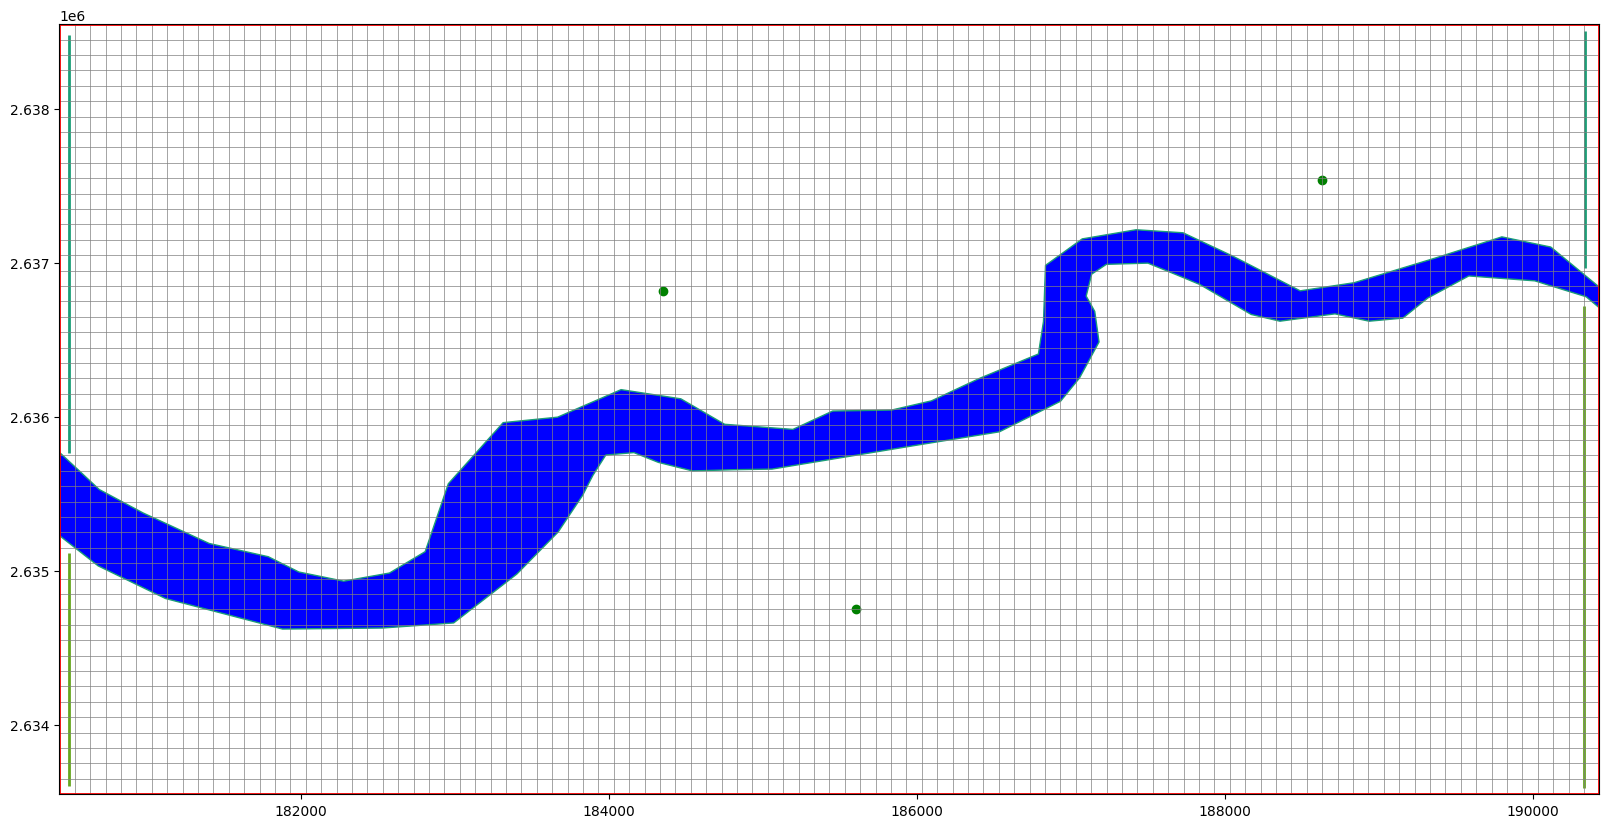

In [10]:
# Representation of model geometry with all the boundary conditions
fig = plt.figure(figsize=(20, 10))

modelmap = flopy.plot.PlotMapView(model=mf)
linecollection = modelmap.plot_grid(linewidth=0.5, color="cyan")

StudyAreaArray = np.array(StudyAreaShp.shapeRecords()[0].shape.points)

WellShp = sf.Reader("Shapefiles/PumpingWell.shp")
WellArray = np.array([point.shape.points[0] for point in WellShp.shapeRecords()])

shpRiver = flopy.plot.plot_shapefile("Shapefiles/River", facecolor="blue")  # RIV boundary condition
shpWestGHB = flopy.plot.plot_shapefile(
    "Shapefiles/WestGHB", facecolor="none", linewidth=2
)  # GHB boundary condition
shpEastGHB = flopy.plot.plot_shapefile("Shapefiles/EastGHB.shp", facecolor="none", linewidth=2)

plt.plot(StudyAreaArray[:, 0], StudyAreaArray[:, 1], color="red", linewidth=2)
plt.scatter(WellArray[:, 0], WellArray[:, 1], color="green")

### Reassign the Model top and Bottom Elevation

#### Read the TXT file storing Elevation values

In [11]:
DEM = pd.read_table("Textfiles\DEM.txt", sep=",")
DEM.head(2)

,FID,pointid,grid_code,POINT_X,POINT_Y
0,73283,73284,11,180523.143933,2.638478e+06
1,73284,73285,10,180723.143933,2.638478e+06


#### Interpolate the values into Model Grid Cells

In [12]:
points = DEM[["POINT_X", "POINT_Y"]].values
values = DEM["grid_code"].values
grid_x = mf.modelgrid.xcellcenters
grid_y = mf.modelgrid.ycellcenters
ztop = griddata(points, values, (grid_x, grid_y), method="nearest")
botm = [ztop - 20, ztop - 30, -70]

# Reassign the values
mf.dis.top = ztop
mf.dis.botm = botm

## BASIC PACKAGE (BAS) - ACTIVE DOMAIN

In [13]:
ibound_Data = np.ones((nlay, nrow, ncol))
bas = flopy.modflow.ModflowBas(mf, ibound=ibound_Data, strt=ztop)

## LAYER PROPERTY FLOW (LPF)

### Read the TXT file storing HK values and interpolate into grid celss

#### Aquifer 1

In [14]:
aqfer_1 = pd.read_table("Textfiles\Aqf_1.txt", sep=",")
aqfer_1.head(2)

,FID,pointid,grid_code,POINT_X,POINT_Y
0,11874,11875,55.137699,180890.290889,2.638253e+06
1,11875,11876,56.698601,181390.290889,2.638253e+06


In [15]:
points = aqfer_1[["POINT_X", "POINT_Y"]].values
values = aqfer_1["grid_code"].values
grid_x = mf.modelgrid.xcellcenters
grid_y = mf.modelgrid.ycellcenters
aqfer_1_Array = griddata(points, values, (grid_x, grid_y), method="nearest")

#### Aquifer 2

In [16]:
aqfer_2 = pd.read_table("Textfiles\Aqf_2.txt", sep=",")
aqfer_2.head(5)

,FID,pointid,grid_code,POINT_X,POINT_Y
0,11874,11875,46.175400,180890.290889,2.638253e+06
1,11875,11876,44.345402,181390.290889,2.638253e+06
2,11876,11877,42.335999,181890.290889,2.638253e+06
3,11877,11878,40.263802,182390.290889,2.638253e+06
4,11878,11879,38.476601,182890.290889,2.638253e+06


In [17]:
points = aqfer_2[["POINT_X", "POINT_Y"]].values
values = aqfer_2["grid_code"].values
grid_x = mf.modelgrid.xcellcenters
grid_y = mf.modelgrid.ycellcenters
aqfer_2_Array = griddata(points, values, (grid_x, grid_y), method="nearest")

#### Create LPF Object

In [18]:
print(nlay, nrow, ncol)

3 50 100


In [19]:
horizontal_K = np.zeros((nlay, nrow, ncol))
horizontal_K[0] = aqfer_1_Array
horizontal_K[-1] = aqfer_2_Array
horizontal_K[1, :, :] = 0.01

vertical_K = horizontal_K / 10.0

In [20]:
lpf = flopy.modflow.ModflowLpf(mf, hk=horizontal_K, vka=vertical_K, laytyp=1, ipakcb=53)

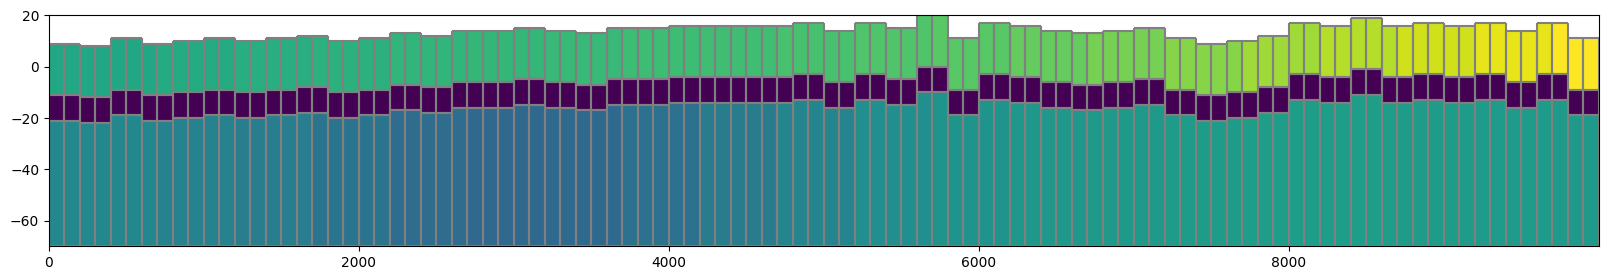

In [21]:
ShowCrossSectionwithHK(15)

## CREATE GRIDGEN OBJECT

In [22]:
gridgen_ws = os.path.join(cwd, "Gridgen_Data" + "\\" + modelname)
if not os.path.exists(gridgen_ws):
    os.makedirs(gridgen_ws)

gridgen_main = Gridgen(
    mf.dis, model_ws=gridgen_ws, exe_name="Exe\gridgen_x64.exe", surface_interpolation="replicate"
)
gridgen_main.build(verbose=False)

## RECHARGE AND EVAPOTRANSPIRATION PACKAGE

### Evapotranspiration

In [23]:
# We apply recharge to the extension of the irrigated areas and evapotranspiration to the whole extent,
# The recharge rate is estimated in 200 mm /yr and the potential evapotraspiration is 1200 mm/yr

# Evapotranspiration rate
evtr = 1.2 / 365.0  # 1200 mm/yr in meter/day
evt = flopy.modflow.ModflowEvt(mf, evtr=evtr, surf=ztop, exdp=1, nevtop=3)

### Recharge

In [24]:
# Recharge rate
rechRate = 1.0 / 365.0  # 1000 mm/yr in meter/day
rech_intersect = gridgen_main.intersect("Shapefiles/Recharge", "polygon", 0)

# empty dictionary for all stress periods, actually spd comes from stress period data
rech_spd = {}

# empty list as the first item of dictionary for the first stress period
rech_spd[0] = np.zeros([nrow, ncol])

In [25]:
# unique cells where recharge is applied, the np.unique also sorts the cell number
rech_unique = np.unique(rech_intersect.nodenumber)

for i in np.arange(rech_unique.shape[0]):
    # get the cell centroid x and y
    x, y = gridgen_main.get_center(rech_unique[i])
    # get the cell row and column
    i, j = mf.sr.get_ij(x, y)
    # add the recharge in the cell to the array for the first stress period
    rech_spd[0][i, j] = rechRate

# Recharge is applied to the highest active cell nrchop = 3 (default)
rec = flopy.modflow.ModflowRch(mf, nrchop=3, rech=rech_spd)

### Plot the EVT and RIV object

## RIVER PACKAGE (RIV)

In [26]:
river_intersect = gridgen_main.intersect("Shapefiles\River", featuretype="polygon", layer=0)
river_spd = {}
river_spd[0] = []

river_unique = np.unique(river_intersect.nodenumber)
for i in np.arange(river_unique.shape[0]):
    try:
        x, y = gridgen_main.get_center(river_unique[i])
    except:
        pass
    i, j = mf.sr.get_ij(x, y)
    # the array follow this order: [lay, row, col, stage, cond, rbot]
    river_spd[0].append([0, i, j, ztop[i, j], 1000, ztop[i, j] - 5])

riv = flopy.modflow.ModflowRiv(mf, stress_period_data=river_spd)

### Plot the RIV object

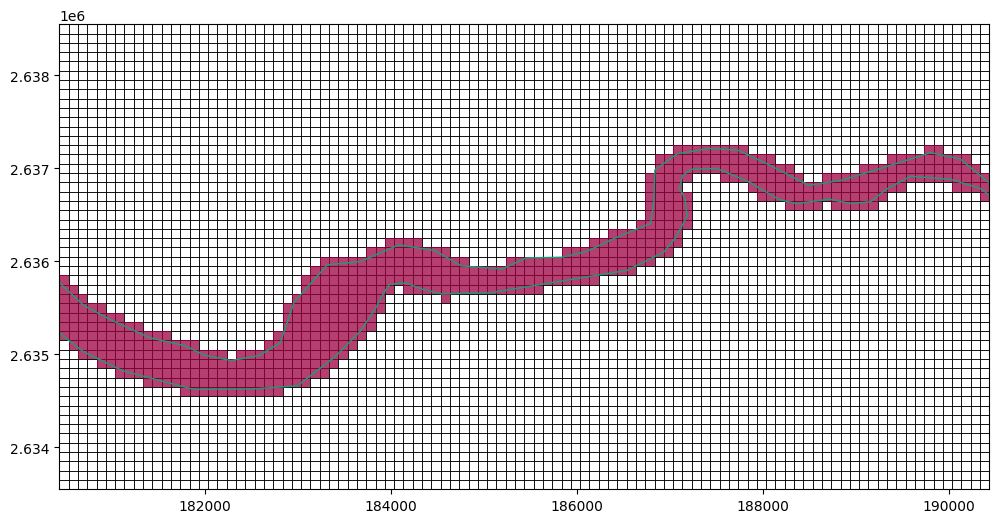

In [27]:
# Plot the river shapefile and the cells conceptualized as river
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
modelmap = flopy.plot.PlotMapView(model=mf)
gridgen_main.plot(ax, linewidth=0.5)
quadmesh = modelmap.plot_array(
    mf.riv.stress_period_data.array["cond"][-1, 0, :, :], cmap="Spectral", ax=ax, alpha=0.5
)
shp = flopy.plot.plot_shapefile("Shapefiles/River", ax=ax, facecolor="none")

## GENERAL HEAD BOUNDARY (GHB)

In [28]:
east_ghb_intersect = gridgen_main.intersect("Shapefiles\EastGHB", featuretype="line", layer=0)
west_ghb_intersect = gridgen_main.intersect("Shapefiles\WestGHB", featuretype="line", layer=0)

ghb_spd = {}
ghb_spd[0] = []

east_ghb_unique = np.unique(east_ghb_intersect.nodenumber)
west_ghb_unique = np.unique(west_ghb_intersect.nodenumber)

for i in np.arange(east_ghb_unique.shape[0]):
    try:
        x, y = gridgen_main.get_center(east_ghb_unique[i])
    except:
        continue
    i, j = mf.sr.get_ij(x, y)
    # the array follow this order: [lay, row, col, elev, cond
    ghb_spd[0].append([0, i, j, ztop[i, j], 500])

for i in np.arange(west_ghb_unique.shape[0]):
    try:
        x, y = gridgen_main.get_center(west_ghb_unique[i])
    except:
        pass
    i, j = mf.sr.get_ij(x, y)
    # the array follow this order: [lay, row, col, elev, cond
    ghb_spd[0].append([0, i, j, ztop[i, j], 500])

In [29]:
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=ghb_spd)

### Plot the GHB Object

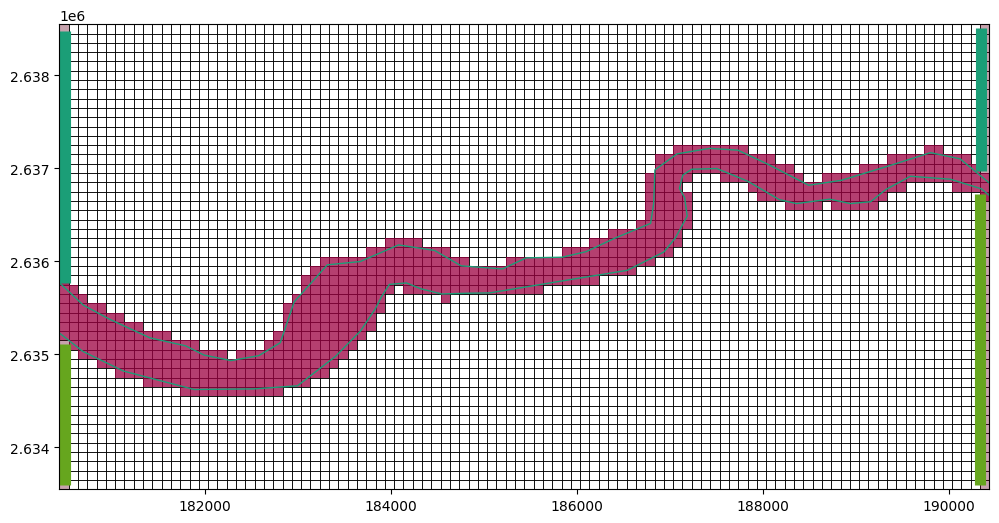

In [30]:
# Plot the GHB shapefile and the cells conceptualized as GHB
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
modelmap = flopy.plot.PlotMapView(model=mf)
gridgen_main.plot(ax, linewidth=0.5)
quadmesh_1 = modelmap.plot_array(
    mf.ghb.stress_period_data.array["cond"][-1, 0, :, :], cmap="RdGy", ax=ax, alpha=0.2
)
quadmesh_1 = modelmap.plot_array(
    mf.riv.stress_period_data.array["cond"][-1, 0, :, :], cmap="Spectral", ax=ax, alpha=0.5
)
east_ghbshp = flopy.plot.plot_shapefile("Shapefiles/EastGHB", ax=ax, linewidth=8)
west_ghbshp = flopy.plot.plot_shapefile("Shapefiles/WestGHB", ax=ax, linewidth=8)
river_shp = flopy.plot.plot_shapefile("Shapefiles/River", ax=ax, facecolor="none")

## WELL PACKAGE (WEL)

In [31]:
wel_intersect = gridgen_main.intersect("Shapefiles/PumpingWell", featuretype="point", layer=0)
wel_spd = {}
wel_spd[0] = [0, 0, 0, 0]  # [lay, row, col, flux]
# wells are not pumping on steady state (stress period 1) but
# we have to insert zero pumping rate to at least one cells
wel_spd[1] = []
pump_rate = -6000  # cubic meter / day

wel_unique = np.unique(wel_intersect.nodenumber)
for i in np.arange(wel_unique.shape[0]):
    try:
        x, y = gridgen_main.get_center(wel_unique[i])
    except:
        pass
    i, j = mf.sr.get_ij(x, y)
    wel_spd[1].append([2, i, j, pump_rate])  # layer 2 (aquifer 2)
    wel_spd[1].append([0, i, j, pump_rate])  # layer 0 (aquifer 1)

# in case we want to keep the same pumping rate for entire time
# we just need to set up pumping rate for one stress period
# the following periods will follow the same set-up values of the previous one

In [32]:
wel = flopy.modflow.ModflowWel(mf, stress_period_data=wel_spd)

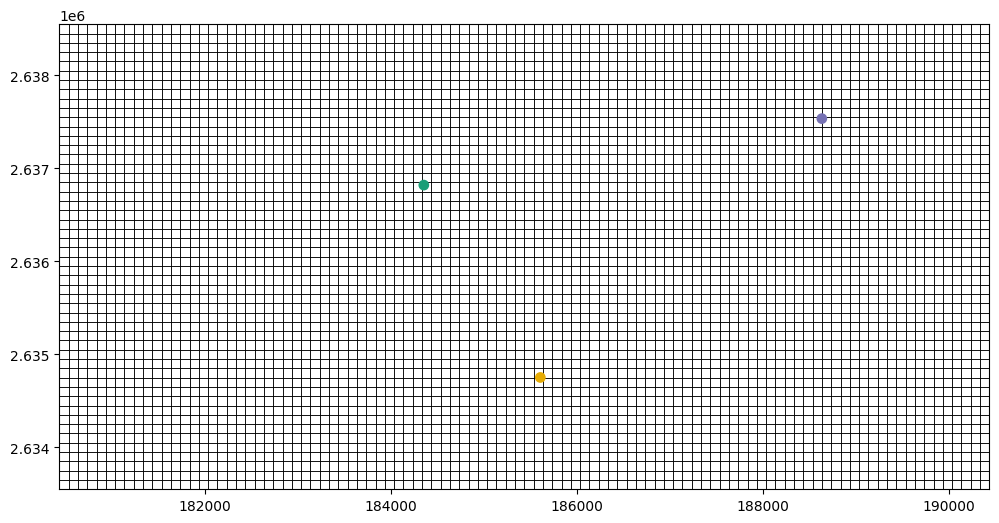

In [33]:
# Plot the well shapefile and the cells conceptualized as wells
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
modelmap = flopy.plot.PlotMapView(model=mf)
gridgen_main.plot(ax, linewidth=0.5)
quadmesh = modelmap.plot_array(
    mf.wel.stress_period_data.array["flux"][-1, 1, :, :], cmap="Spectral", ax=ax
)
shp = flopy.plot.plot_shapefile("Shapefiles/PumpingWell", ax=ax, radius=50)

## SOLVER

In [34]:
gmg = flopy.modflow.ModflowGmg(mf, mxiter=100, iiter=100)

## OUTPUT CONTROL

In [35]:
stress_period_data = {}
for kper in range(nper):
    for kstp in range(int(nstp[kper])):
        stress_period_data[(kper, kstp)] = [
            "save head",
            "save drawdown",
            "save budget",
            "print head",
            "print budget",
        ]
oc = flopy.modflow.ModflowOc(mf, stress_period_data=stress_period_data, compact=True)

## RUN THE MODEL

In [36]:
mf.check()


Example_001 MODEL DATA VALIDATION SUMMARY:
  No errors or warnings encountered.

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    LPF package: vertical hydraulic conductivity values below checker threshold of 1e-11
    LPF package: vertical hydraulic conductivity values above checker threshold of 100000

In [37]:
mf.write_input()

In [38]:
# Run the model
success, mfoutput = mf.run_model(silent=False, pause=False)
if not success:
    raise Exception("MODFLOW did not terminate normally.")

FloPy is using the following  executable to run the model: Exe/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Example_001.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/11/17  0:36:55

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water

# POST-PROCESSING

In [39]:
mfheads = flopy.utils.binaryfile.HeadFile("Model_Data/Example_001/Example_001.hds")
cbb = flopy.utils.CellBudgetFile("Model_Data/Example_001/Example_001.cbc")
frf = cbb.get_data(text="FLOW RIGHT FACE")[0]
fff = cbb.get_data(text="FLOW FRONT FACE")[0]
mytimes = mfheads.get_times()

In [40]:
head = mfheads.get_data(totim=mytimes[-1])
head.shape

(3, 50, 100)

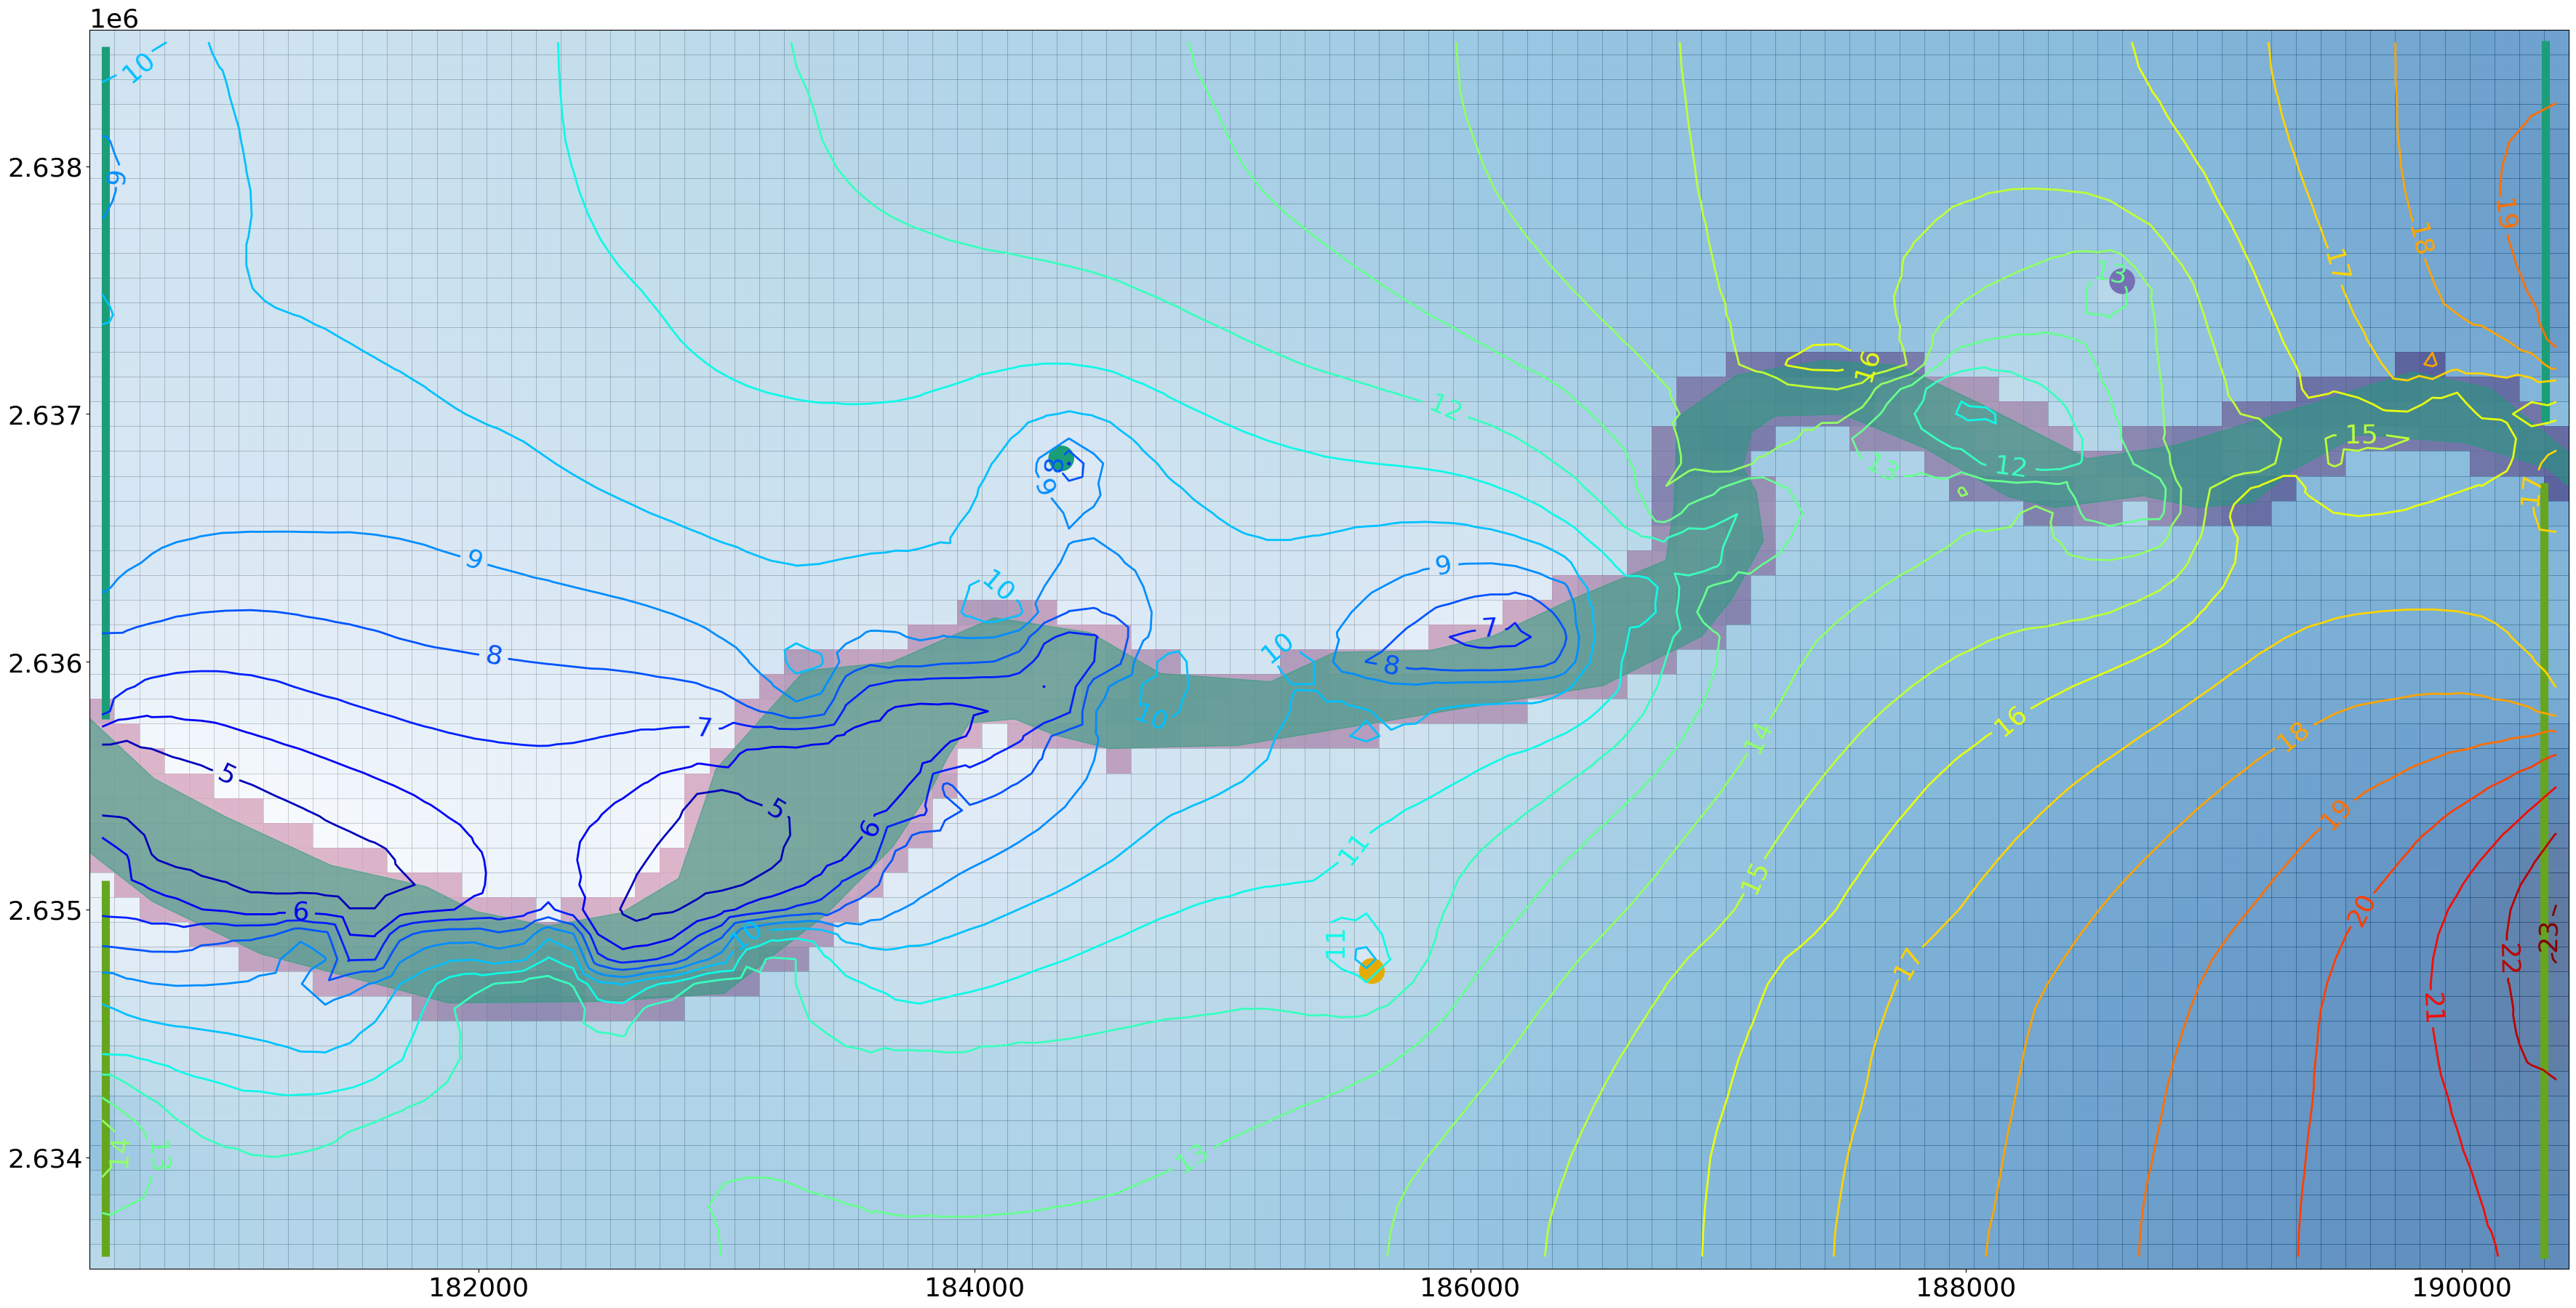

In [41]:
# Plot the heads for a defined layer and boundary conditions
plt.rcParams.update({"font.size": 26})

lay = 0
min_head = np.min(head[lay]).astype(np.int32)
max_head = np.max(head[lay]).astype(np.int32)
extent = np.linspace(min_head, max_head, max_head - min_head + 1)

fig = plt.figure(figsize=(36, 24))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
modelmap = flopy.plot.PlotMapView(model=mf)

gridgen_main.plot(ax, linewidth=0.5, alpha=0.4)

contour = modelmap.contour_array(head[lay], levels=extent, ax=ax, cmap="jet", linewidths=2)

quadmesh = modelmap.plot_array(
    mf.riv.stress_period_data.array["cond"][-1, 0, :, :], cmap="Spectral", ax=ax, alpha=0.5
)

cellhead = modelmap.plot_array(head[lay], ax=ax, masked_values=[999.0], cmap="Blues", alpha=0.4)
# quiver = modelmap.plot_discharge(frf, fff, head=head, alpha=0.5)
# quiver = modelmap.plot_discharge(frf, fff)

ax.clabel(contour)
plt.tight_layout()

# Boundary conditions
east_ghb = flopy.plot.plot_shapefile("Shapefiles\EastGHB", ax=ax, linewidth=8)
west_ghb = flopy.plot.plot_shapefile("Shapefiles\WestGHB", ax=ax, linewidth=8)
wellshp = flopy.plot.plot_shapefile("Shapefiles/PumpingWell", ax=ax, radius=50)
rivshp = flopy.plot.plot_shapefile("Shapefiles\River", ax=ax, alpha=0.5)

# Export heads on the first layer at the beggining of simulation
# contourShp = mfheads.to_shapefile(filename='Shapefiles/ModelHeadsLay2',kstpkper=(0,0),mflay=0)
# fig.savefig('Example_002.png', transparent=False, facecolor='white')

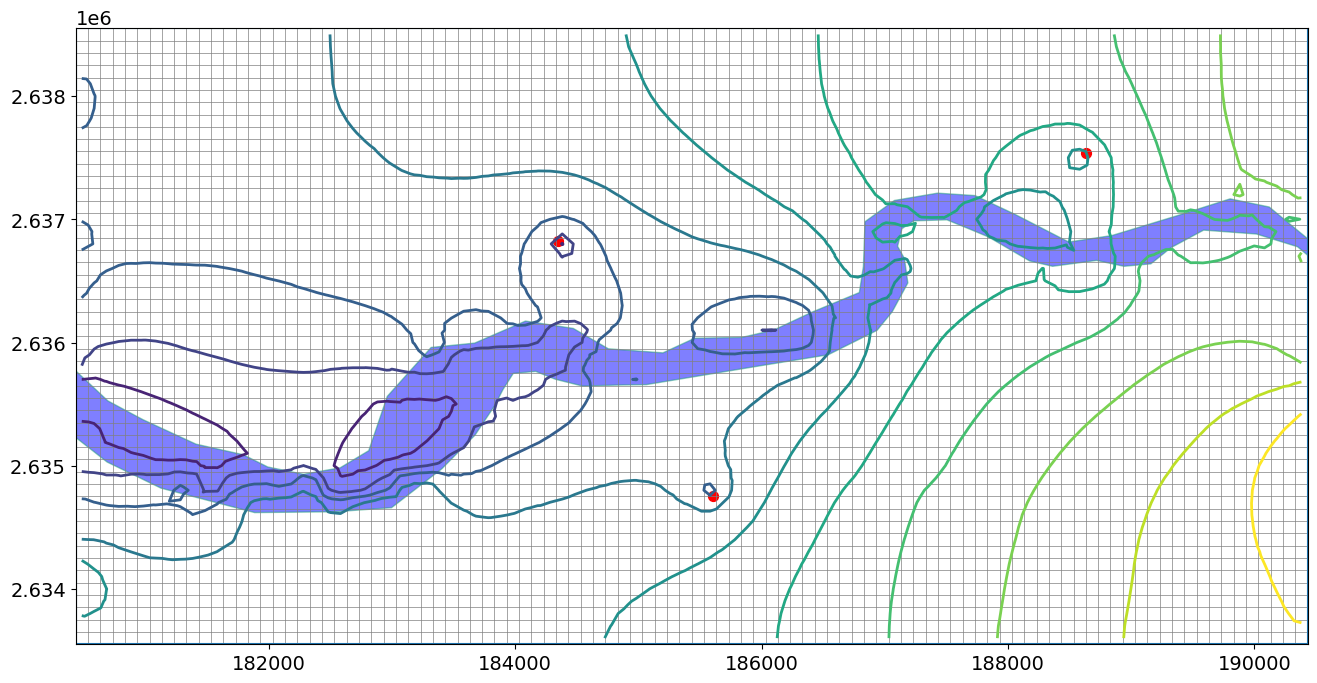

In [42]:
# Representation of model geometry with all the boundary conditions
plt.rcParams.update({"font.size": 14})
fig = plt.figure(figsize=(18, 8))

lay = 1
min_head = np.min(head[lay]).astype(np.int32)
max_head = np.max(head[lay]).astype(np.int32)
extent = np.linspace(min_head, max_head, max_head - min_head + 1)


modelmap = flopy.plot.PlotMapView(model=mf)
linecollection = modelmap.plot_grid(linewidth=0.5, color="cyan")
shpRiver = flopy.plot.plot_shapefile(
    "Shapefiles\River", facecolor="blue", alpha=0.5
)  # RIV boundary condition
east_ghb = flopy.plot.plot_shapefile("Shapefiles\EastGHB", ax=ax, linewidth=8)
west_ghb = flopy.plot.plot_shapefile("Shapefiles\WestGHB", ax=ax, linewidth=8)

contour = modelmap.contour_array(head[lay], levels=extent, linewidths=2)
plt.plot(StudyAreaArray[:, 0], StudyAreaArray[:, 1])
plt.scatter(WellArray[:, 0], WellArray[:, 1], color="red", s=50)

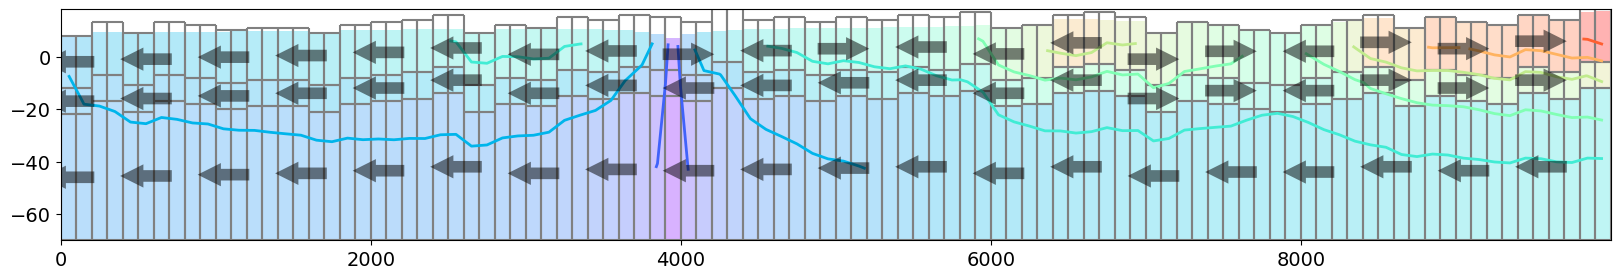

In [43]:
fig = plt.figure(figsize=(20, 3))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=mf, line={"Row": 17})
linecollection = modelxsect.plot_grid()
csa = modelxsect.plot_array(head, masked_values=[999.0], cmap="rainbow", head=head, alpha=0.3)
modelxsect.contour_array(head, cmap="rainbow", linewidths=2)

quiver = modelxsect.plot_discharge(
    frf,
    fff,
    head=head,
    hstep=5,
    normalize=True,
    color="black",
    scale=30,
    headwidth=2,
    headlength=2,
    headaxislength=2,
    zorder=2,
    alpha=0.5,
)